In [1]:
import distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import ppi
import ppi_py
import scipy.stats as stats
import pandas as pd
import ml_models as ml
import distributions as dist

import yaml
import os
import sys
import argparse
import plotting
import copy

C:\Users\huanziy\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Notebook for testing things that are/aren't working

In [2]:
def test(config):
    rho_vals = [.1]
    pop_config = config['experiment']['parameters']['gold_population']
    for rho in rho_vals:
        #pop_config['y_population']['rho'] = rho
        x_gold, y_gold = dist.sample_population(pop_config)

        print(pop_config['x_population']['size'])

        # print the gold population standard error
        print("Gold Population Standard Error: ", stats.sem(y_gold))

        # plot the x population and the y population
        fig, ax = plt.subplots(2)
        ax[0].hist(x_gold, bins=50)
        ax[0].set_title("X Population")
        ax[1].scatter(x_gold, y_gold, alpha=0.5)
        ax[1].set_title("Y Population")
        plt.show()

        ml_config = config['experiment']['model']

        train_config = copy.deepcopy(pop_config)
        train_config['x_population']['size'] = 10000

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the gold population and the fitted gold population

        fig, ax = plt.subplots(3)

        ax[0].scatter(x_gold, y_gold, alpha=0.5)
        ax[0].set_title("Gold Population")
        ax[1].scatter(x_gold, y_gold_fitted, alpha=0.5)
        ax[1].set_title("Fitted Gold Population")
        ax[2].scatter(x_gold, y_gold, alpha=0.5)
        ax[2].scatter(x_gold, y_gold_fitted, alpha=0.5)
        plt.show()
    

    return 

100
Gold Population Standard Error:  [0.53356172]


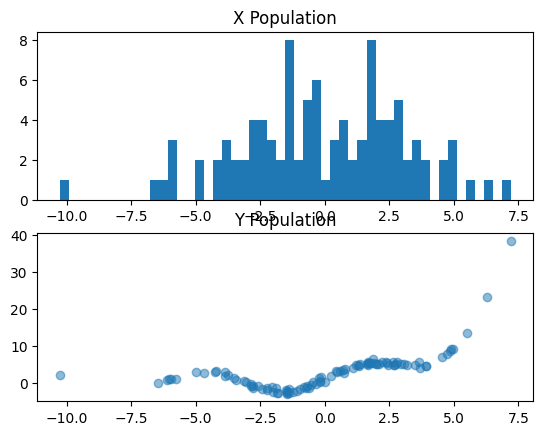

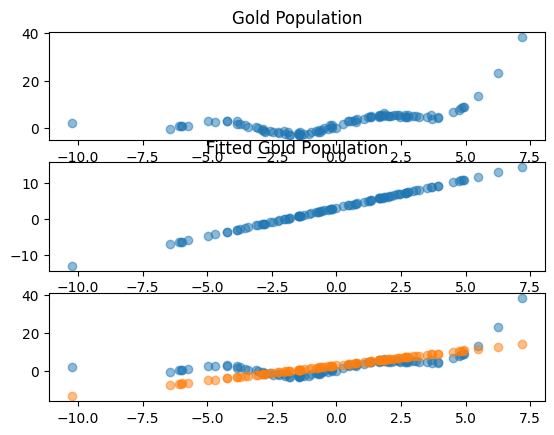

In [3]:
config = "../configs/pptest.yaml"
with open(config, 'r') as stream:
    config = yaml.safe_load(stream)
test(config)

In [4]:
config = "../configs/pptest.yaml"
with open(config, 'r') as stream:
    config = yaml.safe_load(stream)

ppi_pp_win_count = 0
ppi_win_count = 0

relative_improvement = []

for i in range(100):
    # sample

    x_train, y_train = dist.sample_population(config['experiment']['parameters']['training_population'])
    x_gold, y_gold = dist.sample_population(config['experiment']['parameters']['gold_population'])
    x_ppi, y_ppi = dist.sample_population(config['experiment']['parameters']['unlabelled_population'])

    # train
    ml_config = config['experiment']['model']
    model = ml.train_model(x_train, y_train, ml_config)

    # predict
    y_gold_fitted = model.predict(x_gold)
    y_ppi_fitted = model.predict(x_ppi)

    rectifier = np.var(y_gold_fitted - y_gold)
    f_var = np.var(y_ppi_fitted)
    print("Rectifier: ", rectifier, "Normalized Rectifier: ", rectifier/y_gold.shape[0])
    print("Fitted Variance: ", f_var, "Normalized Fitted Variance: ", f_var/y_ppi_fitted.shape[0])
    print("Proportional term:", np.sqrt(rectifier/y_gold.shape[0] + f_var/y_ppi_fitted.shape[0]))

    print("Gold Population Variance: ", np.var(y_gold), "Gold Population Standard Error: ", stats.sem(y_gold))

    print("####################")

    #print(y_ppi_fitted)

    # ppi
    ppi_pp_mean = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_ppi_fitted)
    ppi_pp_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_ppi_fitted, alpha=0.1)

    ppi_mean = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_ppi_fitted, lhat=1)
    ppi_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_ppi_fitted, lhat=1, alpha=0.1)

    classical_mean, classical_ci = ppi.do_classical_ci_mean(y_gold, y_gold_fitted, y_ppi_fitted, .9)

    print("PPI++: ", ppi_pp_mean, ppi_pp_ci, ppi_pp_ci[1] - ppi_pp_ci[0])
    print("PPI: ", ppi_mean, ppi_ci, ppi_ci[1] - ppi_ci[0])
    print("Classical: ", classical_mean, classical_ci, classical_ci[1] - classical_ci[0])

    print("--------------------")
    
    # print the result that performed better
    if ppi_pp_ci[1] - ppi_pp_ci[0] < ppi_ci[1] - ppi_ci[0]:
        print("PPI++ performed better")
        ppi_pp_win_count += 1
    else:
        print("PPI performed better")
        ppi_win_count += 1
    
    # append relative improvement of ppi_pp over ppi
    relative_improvement.append(((ppi_ci[1] - ppi_ci[0]) - (ppi_pp_ci[1] - ppi_pp_ci[0]))/(ppi_ci[1] - ppi_ci[0]))

print("PPI++ Win Count: ", ppi_pp_win_count, "PPI Win Count: ", ppi_win_count)
print("Average Relative Improvement: ", np.mean(relative_improvement))

Rectifier:  39.3755650551202 Normalized Rectifier:  0.393755650551202
Fitted Variance:  18.74399120352549 Normalized Fitted Variance:  0.1874399120352549
Proportional term: 0.7623618318006594
Gold Population Variance:  59.89697304275448 Gold Population Standard Error:  [0.77783027]
####################
PPI++:  [2.74450723] (array([1.58068171]), array([3.90833276])) [2.32765105]
PPI:  [2.66428689] (array([1.41031327]), array([3.91826052])) [2.50794725]
Classical:  2.83213612212375 (1.540633620099323, 4.123638624148177) 2.5830050040488546
--------------------
PPI++ performed better
Rectifier:  20.4069854704037 Normalized Rectifier:  0.20406985470403702
Fitted Variance:  26.20100228213325 Normalized Fitted Variance:  0.2620100228213325
Proportional term: 0.6827004302952866
Gold Population Variance:  34.78577658336928 Gold Population Standard Error:  [0.59276596]
####################
PPI++:  [2.91851383] (array([2.04273716]), array([3.7942905])) [1.75155334]
PPI:  [3.30210162] (array([2.17

In [2]:
def test_mv(config):
    rho_vals = [.1]
    pop_config = config['experiment']['parameters']['gold_population']
    for rho in rho_vals:
        #pop_config['y_population']['rho'] = rho
        x_gold, y_gold = dist.sample_population(pop_config)

        print(pop_config['x_population']['size'])

        # print the gold population standard error
        print("Gold Population Standard Error: ", stats.sem(y_gold))

        ml_config = config['experiment']['model']

        train_config = copy.deepcopy(pop_config)
        train_config['x_population']['size'] = 10000

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the gold population and the fitted gold population

        fig, ax = plt.subplots(3)

        ax[0].scatter(x_gold, y_gold, alpha=0.5)
        ax[0].set_title("Gold Population")
        ax[1].scatter(x_gold, y_gold_fitted, alpha=0.5)
        ax[1].set_title("Fitted Gold Population")
        ax[2].scatter(x_gold, y_gold, alpha=0.5)
        ax[2].scatter(x_gold, y_gold_fitted, alpha=0.5)
        plt.show()
    

    return 

3
(100, 3)
100
Gold Population Standard Error:  [0.63828444]
3
(10000, 3)


ValueError: x and y must be the same size

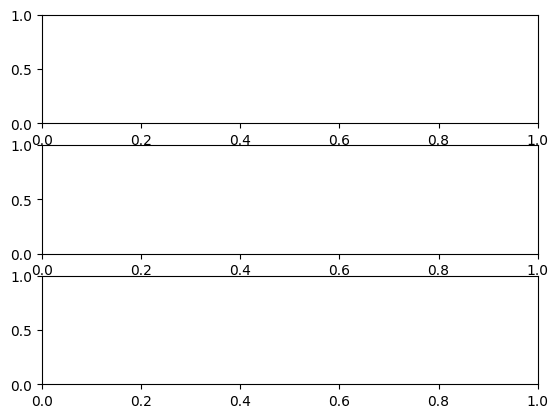

In [3]:
config = "../configs/pptest_mv.yaml"
with open(config, 'r') as stream:
    config = yaml.safe_load(stream)
test_mv(config)

In [4]:
x = np.random.normal(0, 1, (100, 3))
print(x)
print(x.shape)

[[ 3.11834898e-01 -5.97984897e-01 -5.45119609e-02]
 [ 1.63978792e+00 -5.42753772e-01 -1.46106316e+00]
 [ 8.59955409e-01  4.15118780e-01 -1.48364047e+00]
 [-4.42259081e-01 -3.10026966e-01 -9.04339463e-01]
 [ 1.05748950e+00 -4.53121498e-01  9.90807544e-01]
 [ 7.47593080e-01  7.19985844e-01 -2.50265312e-01]
 [ 5.33012209e-01 -1.65870806e+00  5.96683229e-01]
 [-6.71622187e-01  4.77950814e-01  5.71886150e-02]
 [ 3.26929626e-01 -2.04219881e+00  1.16658457e+00]
 [ 2.63487644e-01  4.42448431e-01 -1.64868805e-01]
 [-5.02131671e-01 -7.66730379e-01  7.15437506e-01]
 [-5.11987810e-01  1.41731701e+00  1.42799397e+00]
 [ 1.83499932e+00  3.57886909e-01 -1.28937147e+00]
 [ 2.35219488e-01 -4.29981660e-01 -6.00817020e-01]
 [ 1.03697852e+00  5.71308526e-02 -6.18782704e-01]
 [ 3.66851800e-01 -7.62176027e-01 -6.61091769e-01]
 [-3.62379073e-02  7.81121990e-01 -6.85622568e-01]
 [-8.67620227e-01 -1.12124461e+00  1.30517806e+00]
 [ 1.16559290e+00 -8.83580493e-02 -9.59052542e-01]
 [ 1.42573285e+00 -8.24219986e-

In [5]:
config = "../configs/pptest_mv.yaml"
with open(config, 'r') as stream:
    config = yaml.safe_load(stream)

ppi_pp_win_count = 0
ppi_win_count = 0

relative_improvement = []

for i in range(100):
    # sample

    x_train, y_train = dist.sample_population(config['experiment']['parameters']['training_population'])
    x_gold, y_gold = dist.sample_population(config['experiment']['parameters']['gold_population'])
    x_ppi, y_ppi = dist.sample_population(config['experiment']['parameters']['unlabelled_population'])

    # train
    ml_config = config['experiment']['model']
    model = ml.train_model(x_train, y_train, ml_config)

    # predict
    y_gold_fitted = model.predict(x_gold)
    y_ppi_fitted = model.predict(x_ppi)

    rectifier = np.var(y_gold_fitted - y_gold)
    f_var = np.var(y_ppi_fitted)
    print("Rectifier: ", rectifier, "Normalized Rectifier: ", rectifier/y_gold.shape[0])
    print("Fitted Variance: ", f_var, "Normalized Fitted Variance: ", f_var/y_ppi_fitted.shape[0])
    print("Proportional term:", np.sqrt(rectifier/y_gold.shape[0] + f_var/y_ppi_fitted.shape[0]))

    print("Gold Population Variance: ", np.var(y_gold), "Gold Population Standard Error: ", stats.sem(y_gold))

    print("####################")

    #print(y_ppi_fitted)

    # ppi
    ppi_pp_mean = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_ppi_fitted)
    ppi_pp_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_ppi_fitted, alpha=0.1)

    ppi_mean = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_ppi_fitted, lhat=1)
    ppi_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_ppi_fitted, lhat=1, alpha=0.1)

    classical_mean, classical_ci = ppi.do_classical_ci_mean(y_gold, y_gold_fitted, y_ppi_fitted, .9)

    print("PPI++: ", ppi_pp_mean, ppi_pp_ci, ppi_pp_ci[1] - ppi_pp_ci[0])
    print("PPI: ", ppi_mean, ppi_ci, ppi_ci[1] - ppi_ci[0])
    print("Classical: ", classical_mean, classical_ci, classical_ci[1] - classical_ci[0])

    print("--------------------")
    
    # print the result that performed better
    if ppi_pp_ci[1] - ppi_pp_ci[0] < ppi_ci[1] - ppi_ci[0]:
        print("PPI++ performed better")
        ppi_pp_win_count += 1
    else:
        print("PPI performed better")
        ppi_win_count += 1
    
    # append relative improvement of ppi_pp over ppi
    relative_improvement.append(((ppi_ci[1] - ppi_ci[0]) - (ppi_pp_ci[1] - ppi_pp_ci[0]))/(ppi_ci[1] - ppi_ci[0]))

print("PPI++ Win Count: ", ppi_pp_win_count, "PPI Win Count: ", ppi_win_count)
print("Average Relative Improvement: ", np.mean(relative_improvement))

3
(30000, 1)


IndexError: index 1 is out of bounds for axis 1 with size 1

In [84]:
stats.sem(np.array([1, 2, 3, 4]))

0.6454972243679028

In [2]:
gamma_1 = np.random.gamma(2, 2, 100000).flatten()
gamma_2 = np.random.gamma(5, 6, 100000).flatten()

wass = stats.wasserstein_distance(gamma_1, gamma_2)
print(wass)

26.022687908066292
